<a href="https://colab.research.google.com/github/Leonild/DS_mAIstros/blob/main/KNN_Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Data Predictions  Linear Regression and KNN

The code is available on: https://github.com/Leonild/DS_mAIstros/blob/main/KNN_Linear_regression.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Linear Regression Models

### Simple Linear Regression

In [2]:
class SimpleLinearRegression():
  def fit(self, X, y):
    self.y = y
    self.d = np.mean(X**2) - np.mean(X)**2 # deminator
    self.w0 = (np.mean(y) * np.mean(X**2) - np.mean(X) * np.mean(X*y)) / self.d
    self.w1 = (np.mean(X * y) - (np.mean(X) * np.mean(y))) / self.d

  def predict(self, X, show=0):
    y_hat = self.w1 * X + self.w0

    if show:
      plt.figure()
      plt.scatter(X, self.y, s=8)
      plt.plot(X, y_hat, color="#FF0070")

    return y_hat

### Ordinary Least Squares
OLS is a method for estimating the parameters of a linear regression model by minimizing the sum of the squared errors between the predicted values and the actual values. In other words, it finds the line that best fits the data by minimizing the sum of the squares of the distances between the data points and the line.

In [3]:
def OLS(Y, Y_hat, N):
  return (1 / (2 * N) * np.sum((Y-Y_hat)**2))

In [4]:
def R2(Y, Y_hat):
  return (1 - (np.sum((Y-Y_hat)**2) / np.sum((Y-np.mean(Y))**2)))

### Linear Regression with Regularization

In [5]:
class RLinearRegression():
    
    def fit(self, X, y, eta = 1e-3, epochs = 1e3, show_curve = False, lambd = 0, p = 1):
        epochs = int(epochs)
        N, D = X.shape
        Y = y
        
        self.W = np.random.randn(D)
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            Y_hat = self.predict(X)
            J[epoch] = OLS(Y, Y_hat, N) + (lambd/(p*N))*np.linalg.norm(self.W, ord=p, keepdims=True)
            #print((lambd/(p*N))*np.linalg.norm(self.W, ord=p, keepdims=True))
            self.W -= eta*(1/N)*(X.T@(Y_hat - Y) + (1/N)*(lambd*np.abs(self.W)**(p-1)*np.sign(self.W)))
                    
        #print("This is W:", self.W)
        #print("This is J:", J)
        #print("This is P_hat:", P_hat)    
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()        
    def predict(self, X):
        return X @ self.W

### Multivariate Linear Regression

In [6]:
class MVLinearRegression():

  def fit(self, X, y, classs, eta = 1e-3, epochs = 1e3, show_curve = False):
    epochs = int(epochs)
    N, D = X.shape
    Y = y
    # initialize the wights
    self.W = np.random.randn(D) # Gaussian random values with mean 0 and variance 1

    J = np.zeros(epochs)

    for epoch in range(epochs):
      Y_hat = self.predict(X)
      J[epoch] = OLS(Y, Y_hat, N)
      # Weights update Rule
      self.W -= eta * (1 / N) * (X.T @ (Y_hat - Y))

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training curve for class" + str(classs))
      plt.show()
      
  def predict(self, X):
    return X @ self.W


### KNN Regression


In [7]:
class KNNRegressor():

  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X, K, epsilon=1e-3):
    N = len(X)
    y_hat = np.zeros(N) #container for results

    for i in range(N):
      dist2 = np.sum((self.X - X[i])**2, axis=1)
      idxt = np.argsort(dist2)[:K]
      gamma_k = np.exp(-dist2[idxt]) / np.exp(-dist2[idxt]).sum()
      y_hat[i] = gamma_k.dot(self.y[idxt])
    
    return y_hat

## KNN Classificator
Class to clusterizing the houses accourding lat long

In [8]:
class KNNClassifier():

  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X, k, epsilon = 1e-3):
    N = len(X)
    y_hat = np.zeros(N)

    for i in range(N):
      # getting list of distances
      dist2 = np.sum((self.X - X[i]) ** 2, axis=1)
      idxt = np.argsort(dist2)[:k] # the k nearest
      # a list of the 1/distances
      gamma_k = 1 / (np.sqrt(dist2[idxt]+epsilon))
      y_hat[i] = np.bincount(self.y[idxt], weights=gamma_k).argmax()
    
    return y_hat

#What is the average time that they match
def accuracy(y, y_hat):
  return np.mean(y==y_hat)

## Base Geospatial Analysis

In [9]:
from geopy import Nominatim

def getLatLong(address):
  geolocator = Nominatim(user_agent="mAIstros")
  address, points = geolocator.geocode(address)
  lat, lon = points
  return lat, lon

getLatLong("3541 E Cody St, Tucson, AZ 85716")

(32.237106990130016, -110.91733118968236)

## Solution
All calls and proccess in only one object

In [47]:
class Solution():

  # method to fit the 3 model (Knn to get the class, LR to get the price per
  #square foot and LR to get the house rental price)
  def fit(self, X_data_knn, X_data_lr_s, X_data_lr_r, original_data):
    print("Fitting the solution...")
    self.data_set = original_data
    self.fit_KNN(X_data_knn)
    self.fit_MLR1(X_data_lr_s)
    self.fit_MLR_rental(X_data_lr_r)

  def predict(self, address, sqrt_ft):
    data_p = pd.DataFrame(columns=['longitude', 'latitude',  'class', 'sqrt_ft', 'price_sqft'], index=range(1,2))
    data_p['longitude'], data_p['latitude'] = getLatLong(address)
    data_p['sqrt_ft'] = sqrt_ft

    # Standarization
    data_p['sqrt_ft'] = data_p['sqrt_ft'] / max(self.data_set['sqrt_ft'])
    data_p['latitude'] = data_p['latitude'] / 90.0
    data_p['longitude'] = data_p['longitude'] / 180.0

    X_knn = data_p.filter(items=['longitude', 'latitude', 'sqrt_ft']).to_numpy()

    data_p['class'] = self.knn.predict(X_knn, 10)[0]

    X_mlr = data_p.filter(items=['longitude', 'latitude', 'class', 'sqrt_ft']).to_numpy()

    data_p['price_sqft'] = abs(self.models[float(data_p['class'])].predict(abs(X_mlr)) * max(self.data_set['price_sqft']))

    data_p['price_sqft'] = data_p['price_sqft'] / min(self.data_set['price_sqft'])

    X_mlr_rental = data_p.filter(items=['longitude', 'latitude', 'class', 'sqrt_ft', 'price_sqft']).to_numpy()

    return self.mv_linear_rental.predict(X_mlr_rental)

  # model to predict the class based on the location and square foot
  def fit_KNN(self, X_data_knn):
    X = X_data_knn.to_numpy()

    y = np.array(list(map(lambda x: int(x), X[:, 3]))) # getting the class

    X = X[:,:3] # getting all the data but last column

    self.knn = KNNClassifier()
    self.knn.fit(X,y)

  # model to predict the price per square foot based on the class
  def fit_MLR1(self, X_data_lr_p):
    self.models = {}
    X = {}
    Y = {}
    # Standarization
    X_data_lr = X_data_lr_p
    X_data_lr['price_sqft'] = X_data_lr_p['price_sqft'] / max(self.data_set['price_sqft'])
    X_data_lr['sqrt_ft'] = X_data_lr_p['sqrt_ft'] / max(self.data_set['sqrt_ft'])
    X_data_lr['latitude'] = X_data_lr_p['latitude'] / 90.0
    X_data_lr['longitude'] = X_data_lr_p['longitude'] / 180.0

    for classs in set(X_data_lr['class']):
      X = X_data_lr[X_data_lr['class']==classs].to_numpy()
      
      y = np.array(list(map(lambda x: x, X[:, 4]))) # getting the price as price_sqft
      Y[classs] = y
      
      X = X[:,:4] # getting all the data but last column

      if len(X) > 1:
        mv_linear = MVLinearRegression()

        mv_linear.fit(X, y, classs, eta=0.001, epochs=1000000)#, show_curve=True)

        self.models[classs] = mv_linear

  # model to predict the house rental price based on the price per square foot
  def fit_MLR_rental(self, X_data_lr_r):
    X_data_lr_2 = X_data_lr_r

    # Standarization
    X_data_lr_2['price_sqft'] = X_data_lr_2['price_sqft'] / max(self.data_set['price_sqft'])
    X_data_lr_2['sqrt_ft'] = X_data_lr_2['sqrt_ft'] / max(self.data_set['sqrt_ft'])
    X_data_lr_2['latitude'] = X_data_lr_2['latitude'] / 90.0
    X_data_lr_2['longitude'] = X_data_lr_2['longitude'] / 180.0

    X = X_data_lr_2.to_numpy()
    
    y = np.array(list(map(lambda x: x, X[:, 5]))) # getting the rental as y

    X = X[:,:5] # getting all the data but last column

    self.mv_linear_rental = MVLinearRegression()

    self.mv_linear_rental.fit(X, y, classs, eta=0.01, epochs=1000000)


## Importing Data and Data cleaning

In [32]:
sns.set(color_codes=True)
#reading directly from the cloud 
url = 'https://drive.google.com/file/d/1cAWjT15an4NVY-oMi5bVWqnt61pe2lWs/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)
data.head()
#No duplicate data

data=data.drop_duplicates()

data = data.fillna(0) 

data = data.replace("None", np.nan)
# for HOA group by zip code, create a dictionary and replace by lambda
data['HOA'] = data['HOA'].str.replace(',', '')
data["HOA"] = pd.to_numeric(data["HOA"])
data["bedrooms"] = pd.to_numeric(data["bedrooms"]) 
data["bathrooms"] = pd.to_numeric(data["bathrooms"]) 
data["sqrt_ft"] = pd.to_numeric(data["sqrt_ft"])
grouped_zip = data.groupby("zipcode").mean()
dic = grouped_zip.to_dict()
print(dic['HOA'])

#replace NAN values based on dictionary values
data['HOA'] = data['HOA'].fillna(data['zipcode'].map(dic['HOA']))
data['HOA'] = data['HOA'].fillna(0)
data['sqrt_ft'] = data['sqrt_ft'].fillna(data['zipcode'].map(dic['sqrt_ft']))

data["garage"] = pd.to_numeric(data["garage"])
data['garage'] = data['garage'].fillna(0)

data.head()

{85118: 0.0, 85192: nan, 85541: 0.0, 85601: nan, 85602: 0.0, 85603: nan, 85605: 0.0, 85609: 0.0, 85610: 42.0, 85611: 0.0, 85614: 320.12304347826085, 85615: 81.0, 85619: 75.0, 85621: 8.335, 85622: 56.62157894736842, 85623: 195.055, 85624: 17.142857142857142, 85625: 0.0, 85629: 572.465, 85630: 31.81555555555556, 85637: 24.727272727272727, 85638: nan, 85640: 0.0, 85641: 68.59883333333333, 85643: 0.0, 85645: 0.0, 85646: 151.09820512820514, 85648: 453.3333333333333, 85658: 172.36154981549817, 85701: 7.4, 85704: 11.56111111111111, 85705: 0.0, 85710: 0.0, 85711: 0.0, 85712: 67.58763157894737, 85713: 68.0, 85715: 65.0520224719101, 85716: 1.844155844155844, 85718: 94.26371059013744, 85719: 20.472727272727273, 85730: 23.333333333333332, 85737: 53.100112781954884, 85739: 440.5607638888889, 85742: 36.601451612903226, 85743: 45.83653846153846, 85745: 53.543577235772354, 85747: 42.0, 85748: 38.77777777777778, 85749: 50.80044642857143, 85750: 91.42067658998647, 85755: 144.59660633484165, 85901: 150.0

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10.0,10500.000000,0.0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0.000000
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.000000,0.0,"Dishwasher, Garbage Disposal",5,"Natural Stone, Other",0.000000
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,4151.479167,0.0,"Dishwasher, Garbage Disposal, Refrigerator",5,"Natural Stone, Other: Rock",151.098205
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.000000,4.0,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4,"Ceramic Tile, Laminate, Wood",151.098205
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.000000,3.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Carpet, Concrete",55.000000


## Choosing the features for the model

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sold_price  5000 non-null   float64
 1   zipcode     5000 non-null   int64  
 2   longitude   5000 non-null   float64
 3   latitude    5000 non-null   float64
 4   lot_acres   5000 non-null   float64
 5   taxes       5000 non-null   float64
 6   year_built  5000 non-null   int64  
 7   bedrooms    5000 non-null   int64  
 8   bathrooms   4994 non-null   float64
 9   sqrt_ft     5000 non-null   float64
 10  garage      5000 non-null   float64
 11  fireplaces  5000 non-null   object 
 12  HOA         5000 non-null   float64
 13  price_sqft  5000 non-null   float64
dtypes: float64(10), int64(3), object(1)
memory usage: 585.9+ KB


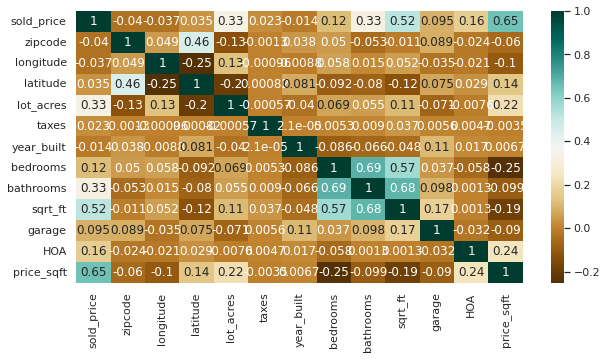

In [33]:
#droping no interesting columns
data = data.drop(['MLS','kitchen_features','floor_covering'],axis=1)
data['price_sqft'] = data['sold_price'] / data['sqrt_ft']
data.info()
plt.figure(figsize=(10,5))
c= data.corr()
sns.heatmap(c, cmap='BrBG', annot=True)
data = data.drop(['zipcode', 'lot_acres', 'taxes', 'fireplaces', 'garage', 'year_built', 'bathrooms'],axis=1)

## Creating the classes

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0}


<Axes: >

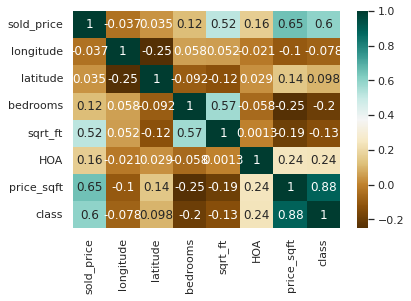

In [34]:
data['price_sqft'].describe() # max 1208 min 24 so a 130 step - 10 classes

data['class'] = list(map(lambda x: x//130, data['price_sqft']))

print(set(data['class']))

X_data_knn = data.filter(items=['longitude', 'latitude', 'sqrt_ft', 'class'])

X_data_lr_original = data.filter(items=['longitude', 'latitude', 'class', 'sqrt_ft', 'price_sqft'])

# shuffle the DataFrame rows to split train and test datas
X_data_knn = X_data_knn.sample(frac = 1)
#print(X_data_lr.head())

#min(X_data_lr_original['sqrt_ft'])
c= data.corr()
sns.heatmap(c, cmap='BrBG', annot=True)

## Adding fake rental price
Creating house rental prices to appli the third model

In [35]:
data['rental_price'] = list(map(lambda x: (x * (40 + 5 * abs(np.random.randn()))), data['price_sqft']))
data['rental_price'].describe()

X_data_lr_rental = data.filter(items=['longitude', 'latitude', 'class', 'sqrt_ft', 'price_sqft', 'rental_price'])

## Testing the solution by module

### Splitting in train and test data set for knn

In [15]:
X = X_data_knn.to_numpy()

X_test = X[int(len(X)*0.9):,:]

X_train = X[:int(len(X)*0.9),:]

print(X_train.shape)
print(X_test.shape)

y_train = np.array(list(map(lambda x: int(x), X_train[:, 3]))) # getting the class

y_test = np.array(list(map(lambda x: int(x), X_test[:, 3]))) # getting the class

X_train = X_train[:,:3] # getting all the data but last column
X_test = X_test[:,:3] # getting all the data but last column

knn = KNNClassifier()
knn.fit(X_train,y_train)

#solution = Solution()
#solution.fit(X_train,y_train)

y_hat = knn.predict(X_train,10)

print("Training accuracy ", accuracy(y_train,y_hat))

y_hat2 = knn.predict(X_test,10)

print("Test accuracy ", accuracy(y_test,y_hat2))

(4500, 4)
(500, 4)
Training accuracy  0.9775555555555555
Test accuracy  0.832


#### Visualizing
Visualizing clusters according lat and long

Text(0, 0.5, 'Longitude')

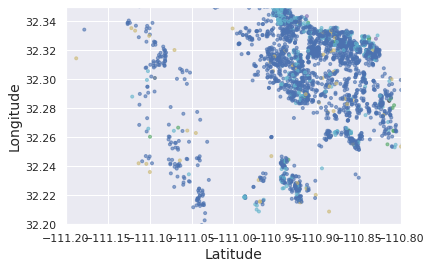

In [16]:
# use colormap
colormap = np.array(['y','b', 'c', 'g','k','m','r','w','y','orchid','crimson','navy','darkviolet'])

plt.figure()
plt.scatter(X_train[:,0],X_train[:,1], c=colormap[y_train], alpha=0.6, s=9)
plt.ylim(32.2, 32.35)
plt.xlim(-111.2, -110.8)
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('Longitude',fontsize=14)

### Splitting in train and test data set for Linear regression (price per square foot)

Should have one model for each class

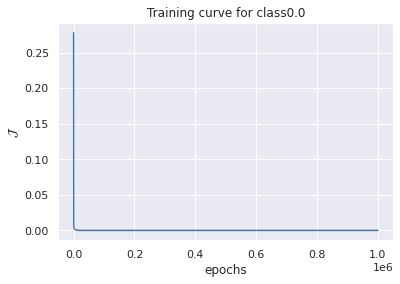

Erro  -0.07787134771407778


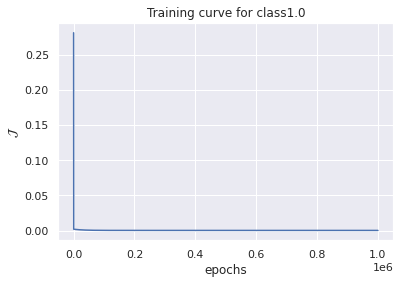

Erro  -0.26536757703114633


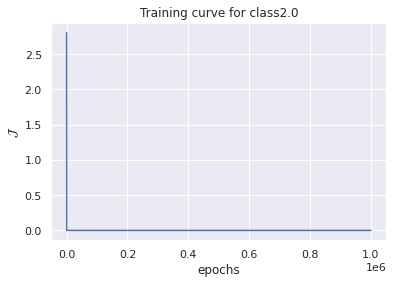

Erro  -0.11318643382695526


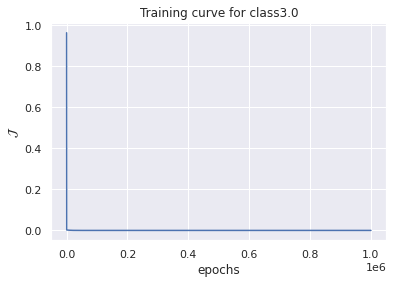

Erro  -0.18094577099146614


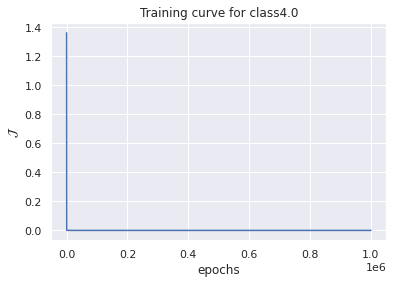

Erro  -18.985992403222877


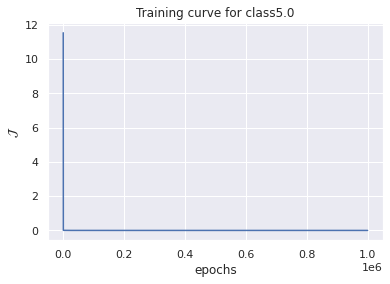

<ipython-input-4-8297140ca4bf>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 - (np.sum((Y-Y_hat)**2) / np.sum((Y-np.mean(Y))**2)))


Erro  -inf


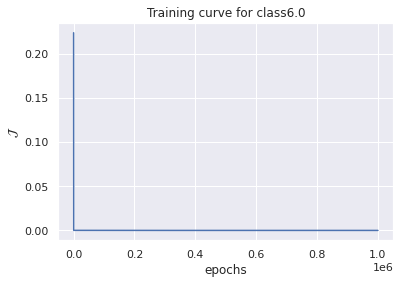

Erro  -inf


In [17]:
X_data_lr = X_data_lr_original
models = {}
X_TRAIN = {}
Y_TRAIN = {}
X_TEST = {}
Y_TEST = {}
Y_HAT = {}
# Standarization
X_data_lr['price_sqft'] = X_data_lr['price_sqft'] / max(X_data_lr['price_sqft'])
X_data_lr['sqrt_ft'] = X_data_lr['sqrt_ft'] / max(X_data_lr['sqrt_ft'])
X_data_lr['latitude'] = X_data_lr['latitude'] / 90.0
X_data_lr['longitude'] = X_data_lr['longitude'] / 180.0
#print(X_data_lr[X_data_lr['class']==2.0].head())
#print(X_train)
# for each class a diferent model
for classs in set(data['class']):
  X_train = X_data_lr[X_data_lr['class']==classs].to_numpy()
  X_test = X_train[int(len(X_train)*0.9):,:]
  X_train = X_train[:int(len(X_train)*0.9),:]
  

  y_train = np.array(list(map(lambda x: x, X_train[:, 4]))) # getting the price as price_sqft
  Y_TRAIN[classs] = y_train
  y_test = np.array(list(map(lambda x: x, X_test[:, 4]))) # getting the price as price_sqft
  Y_TEST[classs] = y_test
  
  X_train = X_train[:,:4] # getting all the data but last column
  X_TRAIN[classs] = X_train
  X_test = X_test[:,:4] # getting all the data but last column
  X_TEST[classs] = X_test

  if len(X_train) > 1:
    mv_linear = MVLinearRegression()
    #mv_linear = KNNRegressor()
    mv_linear.fit(X_train, y_train, classs, eta=0.01, epochs=1000000, show_curve=True)
    #mv_linear.fit(X_train, y_train)
    models[classs] = mv_linear
    y_hat = mv_linear.predict(X_test)
    Y_HAT[classs] = y_hat
    print("Erro ", R2(y_test,y_hat))

#solution = Solution()
#solution.fit(X_train,y_train)

#Y_HAT = dict([(k, models[k].predict(X_TEST[k])) for k in models])
#y_hat = solution.predict("3541 E Cody St, Tucson, AZ 85716", 3620)
# print(X)
#print(Y_HAT)

#### Error

In [18]:
R2_result = [R2(Y_TEST[k],Y_HAT[k]) for k in Y_HAT]
#OLS(y_test,y_hat, len(y_hat))

#print(Y_HAT)
print(R2_result)

[-0.07787134771407778, -0.26536757703114633, -0.11318643382695526, -0.18094577099146614, -18.985992403222877, -inf, -inf]


<ipython-input-4-8297140ca4bf>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 - (np.sum((Y-Y_hat)**2) / np.sum((Y-np.mean(Y))**2)))


#### Visualizing

Text(0.5, 1.0, 'Linear model for predict price per square foot (Class 1)')

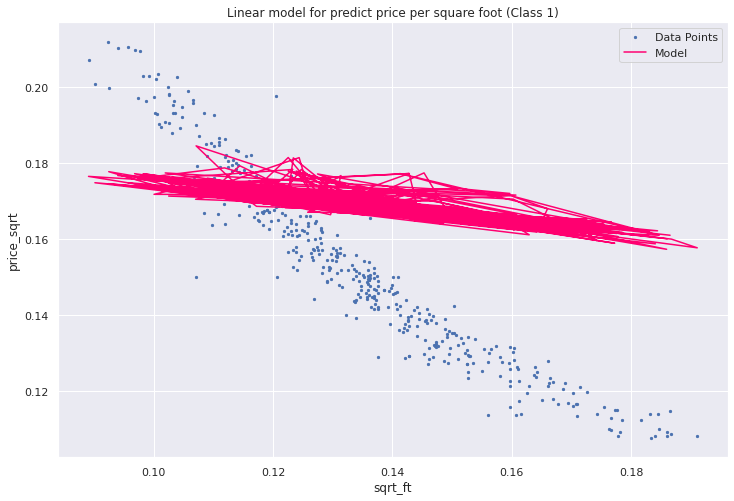

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(X_TEST[1.0][:,3], Y_TEST[1.0], s=5, label='Data Points')
plt.plot(X_TEST[1.0][:,3], Y_HAT[1.0], color="#FF0070", label='Model')
plt.legend()
plt.xlabel("sqrt_ft")
plt.ylabel("price_sqrt")
plt.title("Linear model for predict price per square foot (Class 1)")
#plt.plot(X_test, y_hat2, color="#00FF00")
#plt.plot(X_test, y_hat3, color="#0000FF")

### Splitting in train and test data set for Linear regression (rental price)

Model to predict the house rental price

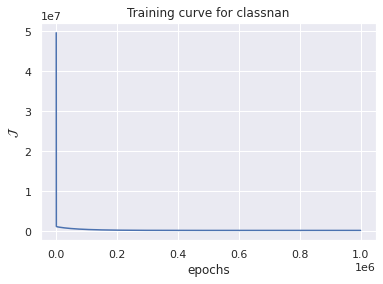

Erro  0.8864654506126485
[[-0.61625742  0.35807217  1.          0.12638343  0.16803039]
 [-0.61584956  0.35912962  1.          0.09777758  0.21076819]
 [-0.61665472  0.36023674  0.          0.20443592  0.10207077]
 ...
 [-0.61530793  0.36627453  2.          0.0790789   0.22184168]
 [-0.61697516  0.35885412  1.          0.16619065  0.12222675]
 [-0.61618363  0.3487251   0.          0.19265441  0.0862668 ]]


In [20]:
X_data_lr_rental = data.filter(items=['longitude', 'latitude', 'class', 'sqrt_ft', 'price_sqft', 'rental_price'])
X_data_lr_2 = X_data_lr_rental

# Standarization
X_data_lr_2['price_sqft'] = X_data_lr_2['price_sqft'] / max(X_data_lr_2['price_sqft'])
X_data_lr_2['sqrt_ft'] = X_data_lr_2['sqrt_ft'] / max(X_data_lr_2['sqrt_ft'])
X_data_lr_2['latitude'] = X_data_lr_2['latitude'] / 90.0
X_data_lr_2['longitude'] = X_data_lr_2['longitude'] / 180.0

X_train = X_data_lr_2.to_numpy()
X_test = X_train[int(len(X_train)*0.9):,:]
X_train = X_train[:int(len(X_train)*0.9),:]


y_train = np.array(list(map(lambda x: x, X_train[:, 5]))) # getting the price as price_sqft

y_test = np.array(list(map(lambda x: x, X_test[:, 5]))) # getting the price as price_sqft


X_train = X_train[:,:5] # getting all the data but last column

X_test = X_test[:,:5] # getting all the data but last column

if len(X_train) > 1:
  mv_linear = MVLinearRegression()
  #mv_linear = KNNRegressor()
  mv_linear.fit(X_train, y_train, np.nan, eta=0.01, epochs=1000000, show_curve=True)
  #mv_linear.fit(X_train, y_train)
  models[classs] = mv_linear
  y_hat = mv_linear.predict(X_test)
  print("Erro ", R2(y_test,y_hat))

print(X_test)

#### Error

In [21]:
R2_result = R2(y_test,y_hat) #OLS(y_test,y_hat, len(y_hat))

#print(Y_HAT)
print(R2_result)
print(X_data_lr_rental)

0.8864654506126485
      longitude  latitude  class   sqrt_ft  price_sqft  rental_price
0     -0.613212  0.348404    3.0  0.468583    0.417734  22341.946421
1     -0.616919  0.351047    4.0  0.325777    0.476145  24533.139001
2     -0.616893  0.351054    7.0  0.185268    0.837259  42550.977691
3     -0.616866  0.351621    3.0  0.402490    0.412921  21358.074990
4     -0.615632  0.358724    4.0  0.285434    0.441412  21410.496406
...         ...       ...    ...       ...         ...           ...
4995  -0.614788  0.354532    1.0  0.160702    0.113762   6599.919264
4996  -0.615881  0.359071    1.0  0.103445    0.196364  10429.945942
4997  -0.615308  0.366275    2.0  0.079079    0.221842  10920.186211
4998  -0.616975  0.358854    1.0  0.166191    0.122227   6766.972904
4999  -0.616184  0.348725    0.0  0.192654    0.086267   4560.435338

[5000 rows x 6 columns]


#### Visualizing

Text(0.5, 1.0, 'Linear model for predict House rental price')

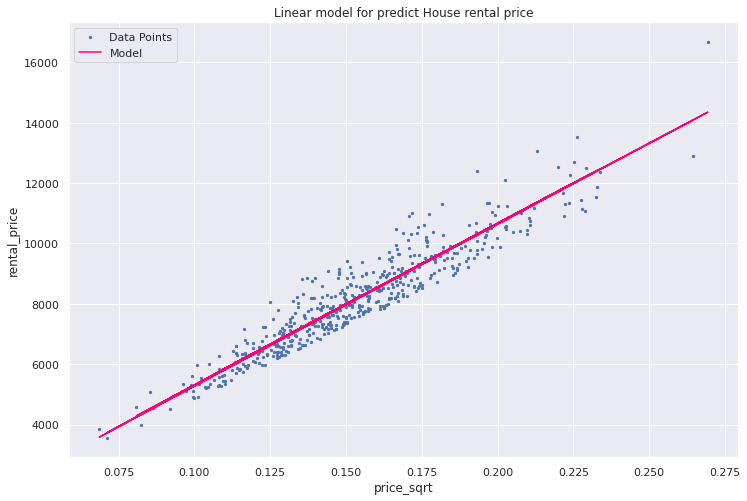

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(X_test[:,4], y_test, s=5, label='Data Points')
plt.plot(X_test[:,4], y_hat, color="#FF0070", label='Model')
plt.legend()
plt.xlabel("price_sqrt")
plt.ylabel("rental_price")
plt.title("Linear model for predict House rental price")
#plt.plot(X_test, y_hat2, color="#00FF00")
#plt.plot(X_test, y_hat3, color="#0000FF")

## Testing the Solution

In [48]:
solution = Solution()

solution.fit(X_data_knn, X_data_lr_original, X_data_lr_rental, data)

#print("The rental price should be ", solution.predict("3541 E Cody St, Tucson, AZ 85716", 620))

Fitting the solution...


In [63]:
print("The rental price should be ", solution.predict("2001 E 6th St, Tucson, AZ 85719", 2370), " dollars")


The rental price should be  [14835.08469739]  dollars


# TODO

Create a colums C= price per sqrt ft. At least 10 categores. The category becomes a class to classify
KNN to groups the categories (lat long) and linear regression to predict the price per sqrt ft 

Metrics for KNN and Linear model. However should have a general metric as well

# Bonus: plotting house location

In [ ]:
from geopy.geocoders import Nominatim
import folium
import pandas as pd

class MapaUS:

	def __init__(self, latitude, longitude, data):
		self.mapa = folium.Map(location=[latitude, longitude], zoom_start=4)
		self.dataset = data

	#converting address to coordinates
	def convertaddressToCoordinate(self, address):
		geolocator = Nominatim()
		location = geolocator.geocode(address) 
		# location = nom.geocode(address)
		# print(location.address)
		# print((location.latitude, location.longitude))
		#return location.latitude, location.longitude
		return location
		

	#creating map (latitude, longitude)
	def addPointMap(self, latitude, longitude):
		#adicionando coordenada no mapa
		folium.Marker([latitude,longitude]).add_to(self.mapa)
		#salvando o mapa
		
	def saveMap(self):
		self.mapa.save("./house-location.html")

if __name__ == "__main__":
  url = 'https://drive.google.com/file/d/1cAWjT15an4NVY-oMi5bVWqnt61pe2lWs/view?usp=share_link'
  path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
  data = pd.read_csv(path)
  dataSet = data
  m = MapaUS(33.904231, -111.969833, dataSet) # creating a map with a central poitn in Arizona
  az = pd.DataFrame()
  for index, row in dataSet.iterrows():
    try:
      #if ( (row['latitude'] < 34.798905) and (row['longitude'] > -118.881730) and (row['latitude'] > 33.705525) and (row['longitude'] < -117.660151) ):
      m.addPointMap(row['latitude'], row['longitude'])
      az = az.append(row, ignore_index=True)
    except:
      print('Bad news!')

  m.saveMap()